In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import squints as sq

## Data loading

In [2]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

In [3]:
train_o.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,1,6,14,6,6,1,1,10,2,1
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,6,11,1,6,1,4,4,1,13,0
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,1,4,21,12,1,16,10,4,9,0
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,13,12,2,4,2,7,1,2,11,1
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,12,2,2,4,1,3,1,11,15,1


In [8]:
prepr = lambda data:sq.depriceize(sq.logize(sq.fillize(sq.relize(sq.deidize(data)))))

ftrainX, ftrainY = prepr(train_o.drop("y",axis=1)), train_o["y"]
# ftrainX, ftestX = sq.normall([ftrainX, prepr(test_o)])

trainX, valX, trainY, valY = sq.splitize(train_o)
# trainX, valX, testX = sq.normall([prepr(trainX), prepr(valX), prepr(test_o)])
trainX, valX, ftestX = prepr(trainX), prepr(valX), prepr(test_o)
testX = ftestX

In [9]:
trainX.head()

,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,bid5,ask1,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,nans
99483,0.693147,1.098612,1.386294,0,0.2,0.182322,0.182322,0.182322,0.182322,0.4,...,1.609438,1.945910,2.397895,1.098612,0.693147,2.639057,3.044522,1.609438,1.791759,False
267931,1.609438,1.945910,2.397895,-2,0.2,0.182322,0.182322,0.182322,0.182322,0.0,...,1.098612,2.302585,2.302585,0.693147,1.098612,1.609438,1.098612,1.386294,1.945910,False
581056,0.693147,1.098612,1.386294,-1,0.8,0.182322,0.182322,0.182322,0.182322,0.0,...,2.564949,0.693147,1.791759,0.693147,0.693147,1.098612,1.098612,1.386294,1.386294,False
414460,0.000000,0.000000,0.000000,0,0.0,0.182322,0.182322,0.182322,0.470004,0.2,...,0.693147,0.693147,2.302585,1.098612,1.945910,1.386294,0.693147,1.609438,1.791759,True
310262,1.945910,1.609438,2.397895,2,0.2,0.182322,0.182322,0.336472,0.182322,0.0,...,2.079442,0.693147,2.197225,1.791759,1.945910,2.564949,1.386294,2.079442,1.098612,False


## Ridge

0.6596386067683182

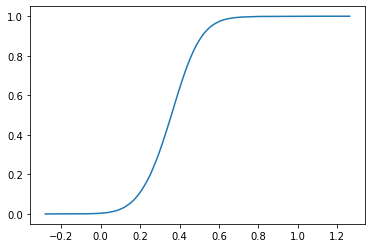

In [10]:
import sklearn.linear_model

ridge = sklearn.linear_model.Ridge(alpha=1)
ridge.fit(trainX, trainY)
p = ridge.predict(valX)
sq.ecdf(p)
sklearn.metrics.roc_auc_score(valY, p)

In [15]:
import sklearn.model_selection

params = {
    "alpha": list(range(1,650,50))
}
gs = sklearn.model_selection.GridSearchCV(
    sklearn.linear_model.Ridge(), params, scoring="roc_auc"
)
gs.fit(trainX, trainY)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1, 51, 101, 151, 201, 251, 301, 351, 401,
                                   451, 501, 551, 601]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

0.659761861669714

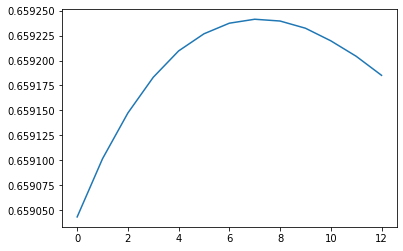

In [16]:
plt.plot(gs.cv_results_["mean_test_score"])
p = gs.predict(valX)
sklearn.metrics.roc_auc_score(valY, p)

## Predict

In [13]:
# fit on all data and predict
ridge = sklearn.linear_model.Ridge(alpha=200)
ridge.fit(ftrainX, ftrainY)

Ridge(alpha=200, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [14]:
# final output requires values in [0,1]
def compress(p):
    return (p - np.min(p)) / (np.max(p)-np.min(p))

ptrain = ridge.predict(ftrainX)
sq.write(train_o["id"], compress(ptrain), "ridge-train.csv")

ptest = ridge.predict(ftestX)
sq.write(test_o["id"], compress(ptest), "ridge-test.csv")